In [16]:
import pandas as pd
import glob
import time
import duckdb
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Create a connection to a DuckDB in-memory database

conn = duckdb.connect(':memory:')

# Define the path to the CSV file

csv_file_path = 'Motor_Vehicle_Collisions_-_Crashes_20240219.csv'


# Create a table from the CSV file using DuckDB's read_csv_auto method

create_table_query = f"""

CREATE TABLE crash_data AS

SELECT *

FROM read_csv_auto('{csv_file_path}', header=true, ignore_errors = true)

"""

conn.execute(create_table_query)

print("Data has been successfully loaded into the 'crash_data' table.")

# Analyze trends over time by aggregating the number of crashes per month

monthly_analysis_query = """

SELECT

    DATE_TRUNC('month', "CRASH DATE") AS month,

    COUNT(*) AS num_crashes

FROM

    crash_data

GROUP BY

    month

ORDER BY

    month

"""

monthly_analysis_result = conn.execute(monthly_analysis_query)

monthly_rows = monthly_analysis_result.fetchall()
print(monthly_rows)

print("Monthly analysis:")

for row in monthly_rows:

    print(row)

    

# Analyze trends over time by aggregating the number of crashes per day of the week

day_of_week_analysis_query = """

SELECT

    DATE_PART('dow', "CRASH DATE") AS day_of_week,

    COUNT(*) AS num_crashes

FROM

    crash_data

GROUP BY

    day_of_week

ORDER BY

    day_of_week

"""

day_of_week_analysis_result = conn.execute(day_of_week_analysis_query)

day_of_week_rows = day_of_week_analysis_result.fetchall()

print("\nDay of the week analysis:")

for row in day_of_week_rows:

    print(row)



# Analyze trends over time by aggregating the number of crashes per hour of the day

hour_of_day_analysis_query = """

SELECT

    SUBSTRING("CRASH TIME", 1, 2) AS hour,

    COUNT(*) AS num_crashes

FROM

    crash_data

GROUP BY

    hour

ORDER BY

    hour

"""

hour_of_day_analysis_result = conn.execute(hour_of_day_analysis_query)

hour_of_day_rows = hour_of_day_analysis_result.fetchall()

print("\nHour of the day analysis:")

for row in hour_of_day_rows:

    print(row)

# Perform spatial aggregation to calculate the total number of crashes within each borough
result = conn.execute('''
    SELECT
        BOROUGH,
        COUNT(*) AS NUM_CRASHES
    FROM
        crash_data
    WHERE
        BOROUGH IS NOT NULL
    GROUP BY
        BOROUGH
''')

# Fetch and print the result
result_df = result.fetchdf()
print(result_df)

# Filter out rows with None borough values
result_df_filtered = result_df[result_df['BOROUGH'].notna()]


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Data has been successfully loaded into the 'crash_data' table.
[(datetime.date(2012, 7, 1), 16990), (datetime.date(2012, 8, 1), 17141), (datetime.date(2012, 9, 1), 16534), (datetime.date(2012, 10, 1), 16862), (datetime.date(2012, 11, 1), 15889), (datetime.date(2012, 12, 1), 17121), (datetime.date(2013, 1, 1), 15641), (datetime.date(2013, 2, 1), 14398), (datetime.date(2013, 3, 1), 16506), (datetime.date(2013, 4, 1), 16439), (datetime.date(2013, 5, 1), 18487), (datetime.date(2013, 6, 1), 18205), (datetime.date(2013, 7, 1), 17578), (datetime.date(2013, 8, 1), 16758), (datetime.date(2013, 9, 1), 16954), (datetime.date(2013, 10, 1), 17713), (datetime.date(2013, 11, 1), 17770), (datetime.date(2013, 12, 1), 17279), (datetime.date(2014, 1, 1), 16674), (datetime.date(2014, 2, 1), 15737), (datetime.date(2014, 3, 1), 15858), (datetime.date(2014, 4, 1), 16371), (datetime.date(2014, 5, 1), 18274), (datetime.date(2014, 6, 1), 18408), (datetime.date(2014, 7, 1), 17458), (datetime.date(2014, 8, 1), 17

         BOROUGH  NUM_CRASHES
0          BRONX       210342
1  STATEN ISLAND        59748
2         QUEENS       381545
3      MANHATTAN       319185
4       BROOKLYN       452471


<class 'list'>


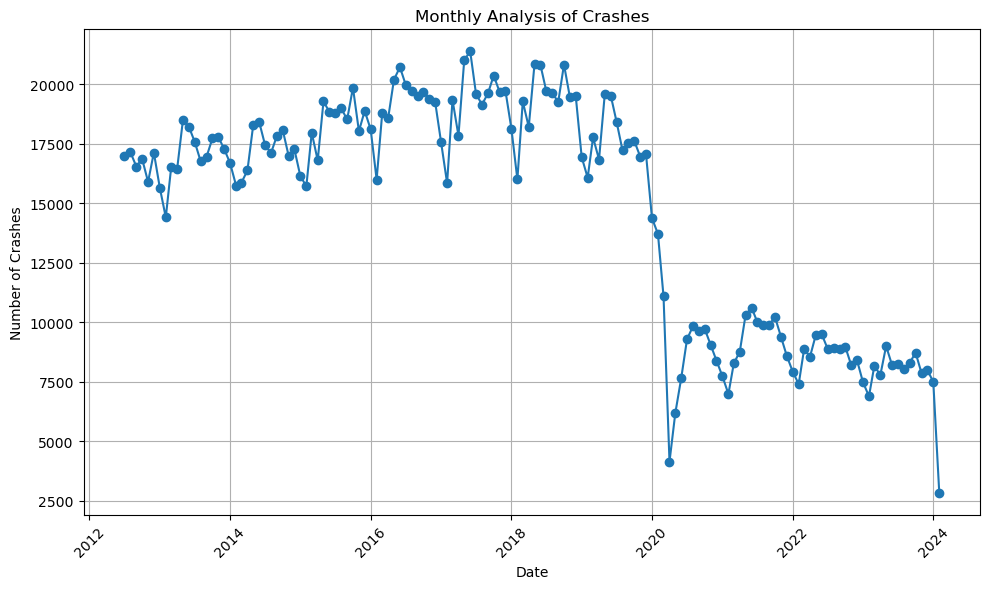

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
# Extracting dates and values
dates = [data[0] for data in monthly_rows]
values = [data[1] for data in monthly_rows]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(dates, values, marker='o', linestyle='-')
plt.title('Monthly Analysis of Crashes')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

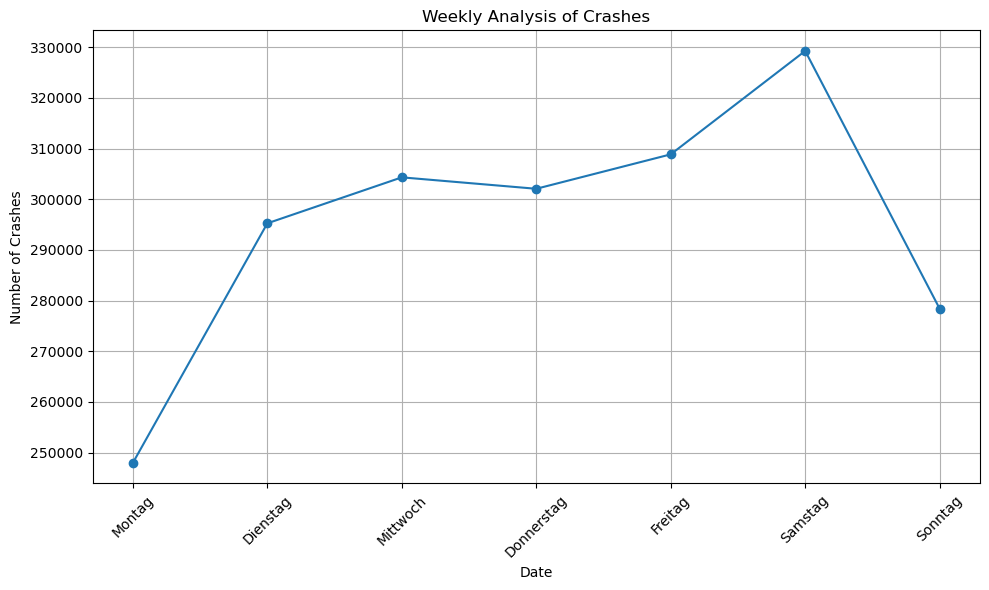

In [17]:
import matplotlib.pyplot as plt
import datetime

# Define custom tick labels for days of the week
custom_labels = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
# Extracting dates and values
dates = [data[0] for data in day_of_week_rows]
values = [data[1] for data in day_of_week_rows]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(dates, values, marker='o', linestyle='-')
plt.title('Weekly Analysis of Crashes')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(range(7), custom_labels, rotation=45)  # Set custom tick labels
plt.grid(True)
plt.tight_layout()
plt.show()

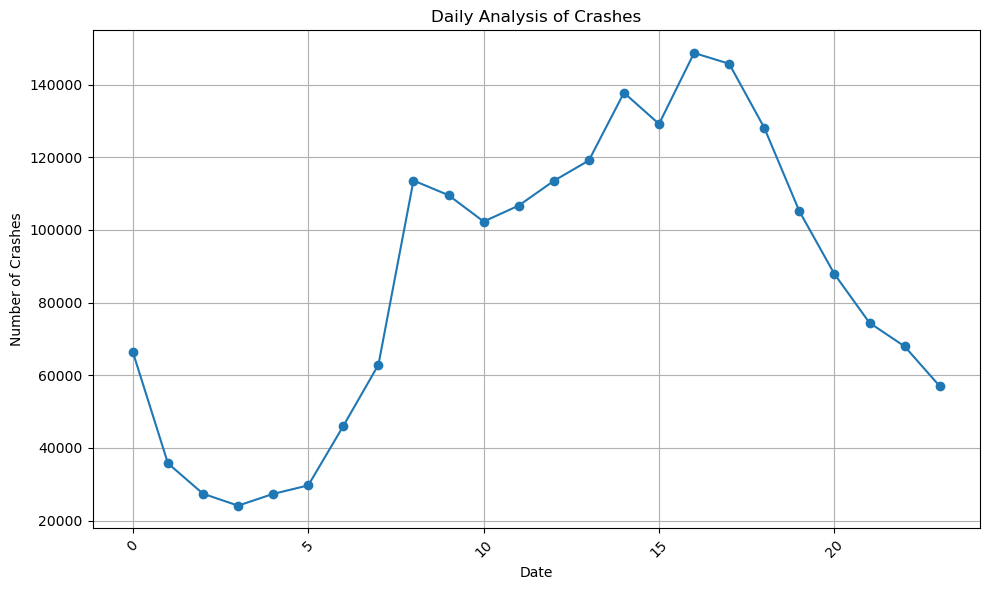

In [5]:
# Remove colons and convert keys to integers for sorting
hour_of_day_rows = [(int(key.replace(':', '')) if ':' in key else int(key), value) for key, value in hour_of_day_rows]

# Sort the data by keys
hour_of_day_rows.sort()

# Extracting dates and values
dates = [data[0] for data in hour_of_day_rows]
values = [data[1] for data in hour_of_day_rows]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(dates, values, marker='o', linestyle='-')
plt.title('Daily Analysis of Crashes')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

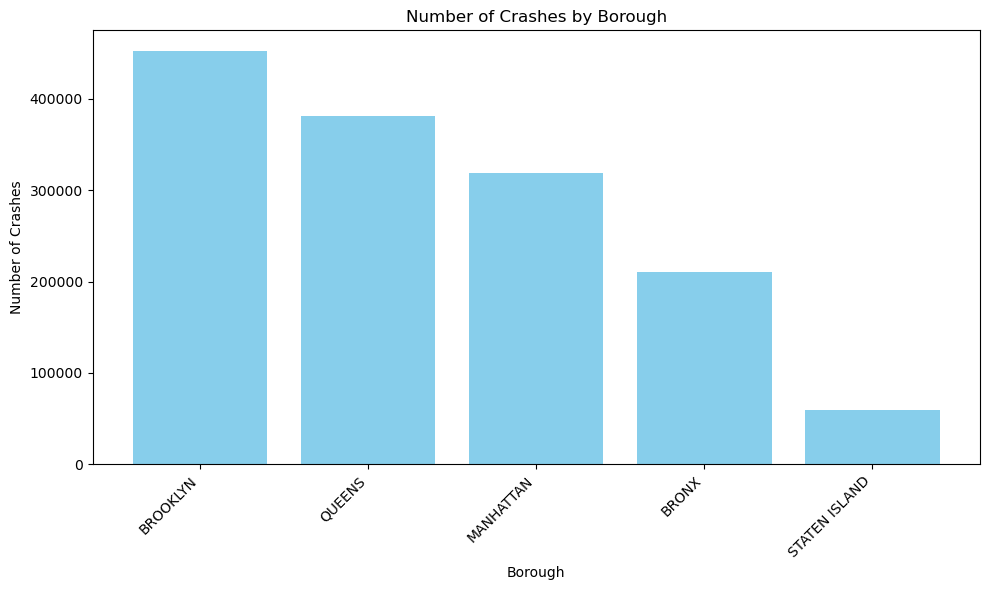

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder  # Add this import statement

# Assuming result_df_filtered contains the filtered data with BOROUGH and NUM_CRASHES columns

# Sort the data by number of crashes in descending order
result_df_sorted = result_df_filtered.sort_values(by='NUM_CRASHES', ascending=False)

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(result_df_sorted['BOROUGH'], result_df_sorted['NUM_CRASHES'], color='skyblue')
plt.title('Number of Crashes by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

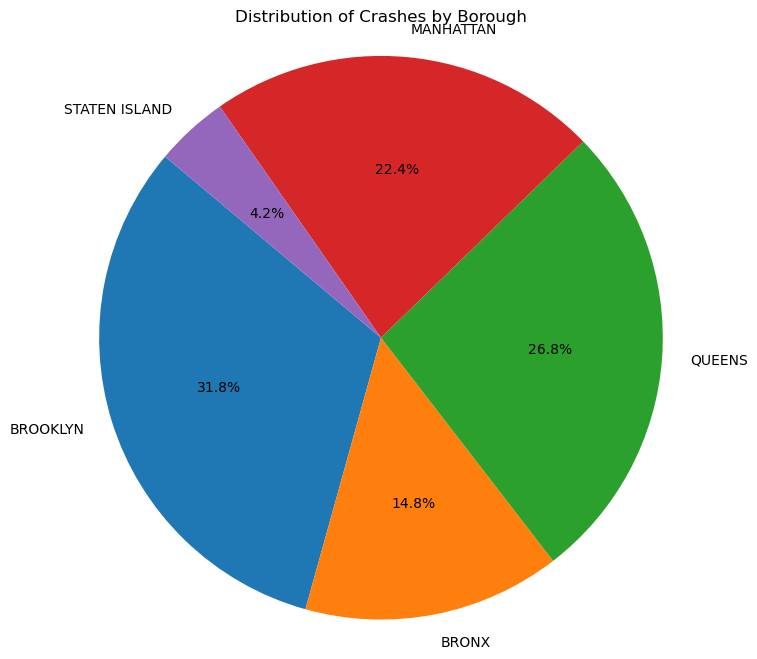

In [11]:
import matplotlib.pyplot as plt

# Assuming result_df_filtered contains the filtered data with BOROUGH and NUM_CRASHES columns

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(result_df_filtered['NUM_CRASHES'], labels=result_df_filtered['BOROUGH'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Crashes by Borough')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [31]:
import duckdb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Connect to DuckDB and load the crash_data table
conn = duckdb.connect(database=':memory:')
csv_file_path = 'Motor_Vehicle_Collisions_-_Crashes_20240219.csv'
create_table_query = f"""
CREATE TABLE crash_data AS
SELECT *
FROM read_csv_auto('{csv_file_path}', header=true, ignore_errors=true)
"""
conn.execute(create_table_query)

# Perform data preprocessing and feature selection
# (Assuming you have already performed these steps)

# Split the data into features (X) and target variable (y)
# Replace 'target_column_name' with the name of your target variable column
X = conn.execute('SELECT feature_column1, feature_column2, ... FROM crash_data').fetchdf()
y = conn.execute('SELECT target_column_name FROM crash_data').fetchdf()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Make predictions on new data
# (Assuming you have new data stored in a DataFrame called 'new_data')
new_data = pd.DataFrame(...)  # Replace ... with your new data
new_predictions = model.predict(new_data)

# Print the predictions
print(new_predictions)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

ParserException: Parser Error: syntax error at or near ".."